# Telecom X – Parte 2: Prevendo a Evasão de Clientes com Machine Learning
**Objetivo:** Após a análise exploratória da Parte 1, este notebook foca na construção e avaliação de modelos de machine learning para prever a evasão (churn) de clientes. O objetivo é criar um pipeline de modelagem, comparar diferentes algoritmos e identificar as variáveis mais influentes na previsão.

## 1. Carga e Pré-processamento dos Dados
Nesta etapa inicial, carregamos o conjunto de dados já limpo da Parte 1 e realizamos as transformações finais para prepará-lo para os algoritmos de machine learning.

### 1.1. Carregamento dos Dados Tratados
Utilizamos o arquivo `dados_tratados_telecom.csv`, gerado ao final da primeira parte do desafio.

In [1]:
import pandas as pd

# Carregando os dados já limpos e tratados da Parte 1
dados_para_modelo = pd.read_csv('dados_tratados_telecom.csv')

print("Dados tratados carregados com sucesso!")
display(dados_para_modelo.head())

Dados tratados carregados com sucesso!


,ID_Cliente,Churn,Genero,Idoso,Parceiro,Dependentes,Meses_Contrato,Servico_Telefonico,Multiplas_Linhas,Servico_Internet,...,Protecao_Dispositivo,Suporte_Tecnico,Streaming_TV,Streaming_Filmes,Contrato,Fatura_Online,Metodo_Pagamento,Gasto_Mensal,Gasto_Total,Gasto_Diario
0,0002-ORFBO,0,1,0,1,1,9,1,No,DSL,...,No,Yes,Yes,No,One year,1,Mailed check,65.6,593.30,2.186667
1,0003-MKNFE,0,0,0,0,0,9,1,Yes,DSL,...,No,No,No,Yes,Month-to-month,0,Mailed check,59.9,542.40,1.996667
2,0004-TLHLJ,1,0,0,0,0,4,1,No,Fiber optic,...,Yes,No,No,No,Month-to-month,1,Electronic check,73.9,280.85,2.463333
3,0011-IGKFF,1,0,1,1,0,13,1,No,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,1,Electronic check,98.0,1237.85,3.266667
4,0013-EXCHZ,1,1,1,1,0,3,1,No,Fiber optic,...,No,Yes,Yes,No,Month-to-month,1,Mailed check,83.9,267.40,2.796667


### 1.2. Remoção de Colunas e Encoding
Removemos colunas irrelevantes para a predição (como `ID_Cliente`) e aplicamos a técnica de *One-Hot Encoding* para transformar as variáveis categóricas restantes em formato numérico.

In [2]:
# Removendo a coluna ID_Cliente
dados_para_modelo.drop('ID_Cliente', axis=1, inplace=True)

# Identificando as colunas categóricas restantes
colunas_categoricas = dados_para_modelo.select_dtypes(include=['object']).columns

# Aplicando o One-Hot Encoding
dados_encoded = pd.get_dummies(dados_para_modelo, columns=colunas_categoricas, drop_first=True)

# Exibindo as primeiras linhas do DataFrame
print("DataFrame após remoção de colunas e One-Hot Encoding:")
display(dados_encoded.head())

DataFrame após remoção de colunas e One-Hot Encoding:


,Churn,Genero,Idoso,Parceiro,Dependentes,Meses_Contrato,Servico_Telefonico,Fatura_Online,Gasto_Mensal,Gasto_Total,...,Suporte_Tecnico_Yes,Streaming_TV_No internet service,Streaming_TV_Yes,Streaming_Filmes_No internet service,Streaming_Filmes_Yes,Contrato_One year,Contrato_Two year,Metodo_Pagamento_Credit card (automatic),Metodo_Pagamento_Electronic check,Metodo_Pagamento_Mailed check
0,0,1,0,1,1,9,1,1,65.6,593.30,...,True,False,True,False,False,True,False,False,False,True
1,0,0,0,0,0,9,1,0,59.9,542.40,...,False,False,False,False,True,False,False,False,False,True
2,1,0,0,0,0,4,1,1,73.9,280.85,...,False,False,False,False,False,False,False,False,True,False
3,1,0,1,1,0,13,1,1,98.0,1237.85,...,False,False,True,False,True,False,False,False,True,False
4,1,1,1,1,0,3,1,1,83.9,267.40,...,True,False,True,False,False,False,False,False,False,True


In [3]:
# Verificando a estrutura final
print("Estrutura do DataFrame para modelagem:\n")
dados_encoded.info()

Estrutura do DataFrame para modelagem:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 32 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Churn                                     7043 non-null   int64  
 1   Genero                                    7043 non-null   int64  
 2   Idoso                                     7043 non-null   int64  
 3   Parceiro                                  7043 non-null   int64  
 4   Dependentes                               7043 non-null   int64  
 5   Meses_Contrato                            7043 non-null   int64  
 6   Servico_Telefonico                        7043 non-null   int64  
 7   Fatura_Online                             7043 non-null   int64  
 8   Gasto_Mensal                              7043 non-null   float64
 9   Gasto_Total                               7043 non-null   float64
 

## 2. Preparação para Modelagem
Com os dados 100% numéricos, verificamos o balanceamento da nossa variável-alvo e separamos o dataset em conjuntos de treino e teste.

### 2.1. Verificação do Balanceamento de Classes
Analisamos a proporção de clientes que evadiram (classe 1) versus os que não evadiram (classe 0) para entender o desbalanceamento do nosso alvo.

In [4]:
from sklearn.model_selection import train_test_split

# 1. Verificando a proporção de Churn
print("Proporção de Churn no dataset:\n")
print(dados_encoded['Churn'].value_counts(normalize=True))

# 2. Separando as features (X) e a variável-alvo (y)
X = dados_encoded.drop('Churn', axis=1)
y = dados_encoded['Churn']

Proporção de Churn no dataset:

Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


### 2.2. Divisão em Dados de Treino e Teste
Separamos os dados em 70% para treino e 30% para teste, utilizando a estratificação para garantir que a proporção de churn seja a mesma em ambos os conjuntos.

In [5]:
# 3. Dividindo os dados em conjuntos de treino e teste
# 70% para treino e 30% para teste.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print(f"\nDados divididos com sucesso!\n")
print(f"Tamanho do conjunto de treino (X_train): {X_train.shape}")
print(f"\nTamanho do conjunto de teste (X_test): {X_test.shape}")


Dados divididos com sucesso!

Tamanho do conjunto de treino (X_train): (4930, 31)

Tamanho do conjunto de teste (X_test): (2113, 31)


## 3. Construção e Avaliação de Modelos
Nesta seção, treinamos e avaliamos dois modelos de classificação com abordagens distintas.

### 3.1. Modelo 1: Random Forest (Sem Normalização)
O Random Forest é um modelo robusto baseado em árvores de decisão que não requer normalização dos dados. Avaliamos sua performance com as principais métricas de classificação.

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Criação e Treinamento do Modelo
modelo_rf = RandomForestClassifier(random_state=42)
print("Treinando o modelo Random Forest...")
modelo_rf.fit(X_train, y_train)
print("\nTreinamento concluído!")

Treinando o modelo Random Forest...

Treinamento concluído!


In [7]:
# 2. Fazendo as Previsões
previsoes_rf = modelo_rf.predict(X_test)

# 3. Avaliação do Modelo
print("--- Métricas de Avaliação (Random Forest) ---")

acuracia = accuracy_score(y_test, previsoes_rf)
print(f"\nAcurácia: {acuracia:.4f}")

precisao = precision_score(y_test, previsoes_rf)
print(f"\nPrecisão: {precisao:.4f}")

recall = recall_score(y_test, previsoes_rf)
print(f"\nRecall: {recall:.4f}")

f1 = f1_score(y_test, previsoes_rf)
print(f"\nF1-Score: {f1:.4f}")

# Relatório de Classificação Completo
print("\nRelatório de Classificação Detalhado:\n")
print(classification_report(y_test, previsoes_rf))

--- Métricas de Avaliação (Random Forest) ---

Acurácia: 0.7861

Precisão: 0.6230

Recall: 0.4920

F1-Score: 0.5498

Relatório de Classificação Detalhado:

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1552
           1       0.62      0.49      0.55       561

    accuracy                           0.79      2113
   macro avg       0.73      0.69      0.70      2113
weighted avg       0.77      0.79      0.78      2113



Matriz de Confusão:



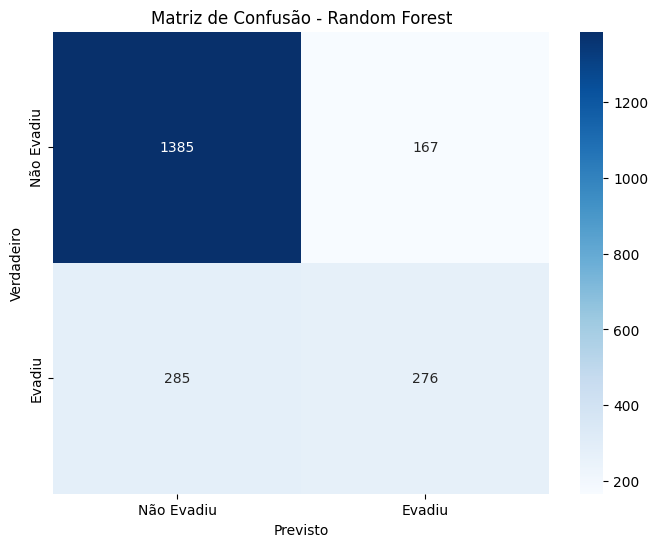

In [8]:
# 4. Matriz de Confusão
print("Matriz de Confusão:\n")
matriz_confusao = confusion_matrix(y_test, previsoes_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Evadiu', 'Evadiu'],
            yticklabels=['Não Evadiu', 'Evadiu'])
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão - Random Forest')
plt.show()

### 3.2. Modelo 2: Regressão Logística (Com Normalização)
A Regressão Logística é um modelo estatístico que, para performar melhor, exige que as variáveis estejam na mesma escala. Portanto, aplicamos a normalização (`StandardScaler`) antes do treinamento.

In [9]:
from sklearn.preprocessing import StandardScaler

# 1. Instanciando o Scaler
scaler = StandardScaler()

# 2. "Aprendendo" a escala a partir dos dados de treino e transformando-os
X_train_normalizado = scaler.fit_transform(X_train)

# 3. Apenas "transformando" os dados de teste com a mesma escala aprendida no treino
X_test_normalizado = scaler.transform(X_test)

X_train_normalizado = pd.DataFrame(X_train_normalizado, columns=X.columns)
X_test_normalizado = pd.DataFrame(X_test_normalizado, columns=X.columns)

print("Dados normalizados com sucesso!")
display(X_train_normalizado.head())

Dados normalizados com sucesso!


,Genero,Idoso,Parceiro,Dependentes,Meses_Contrato,Servico_Telefonico,Fatura_Online,Gasto_Mensal,Gasto_Total,Gasto_Diario,...,Suporte_Tecnico_Yes,Streaming_TV_No internet service,Streaming_TV_Yes,Streaming_Filmes_No internet service,Streaming_Filmes_Yes,Contrato_One year,Contrato_Two year,Metodo_Pagamento_Credit card (automatic),Metodo_Pagamento_Electronic check,Metodo_Pagamento_Mailed check
0,-0.980315,-0.437818,-0.962175,-0.6594,-0.753333,0.314991,-1.224745,0.376295,-0.520505,0.376295,...,-0.642345,-0.5243,-0.792890,-0.5243,-0.800033,-0.519266,-0.564076,-0.527757,1.416368,-0.540618
1,-0.980315,-0.437818,-0.962175,-0.6594,-1.119298,0.314991,0.816497,0.162251,-0.857558,0.162251,...,-0.642345,-0.5243,1.261208,-0.5243,1.249948,1.925796,-0.564076,-0.527757,-0.706031,1.849736
2,-0.980315,-0.437818,1.039312,-0.6594,0.100585,0.314991,0.816497,0.334814,0.117868,0.334814,...,-0.642345,-0.5243,-0.792890,-0.5243,-0.800033,-0.519266,-0.564076,-0.527757,1.416368,-0.540618
3,-0.980315,-0.437818,1.039312,-0.6594,1.035828,0.314991,0.816497,0.696532,1.130713,0.696532,...,-0.642345,-0.5243,1.261208,-0.5243,1.249948,-0.519266,1.772811,-0.527757,1.416368,-0.540618
4,1.020080,-0.437818,-0.962175,-0.6594,-1.241286,0.314991,0.816497,-0.514727,-0.959398,-0.514727,...,-0.642345,-0.5243,-0.792890,-0.5243,-0.800033,-0.519266,-0.564076,-0.527757,-0.706031,1.849736


In [10]:
from sklearn.linear_model import LogisticRegression

# 1. Criação e Treinamento do Modelo com os dados NORMALIZADOS
modelo_logistica = LogisticRegression(random_state=42)

print("Treinando o modelo de Regressão Logística...")
modelo_logistica.fit(X_train_normalizado, y_train)
print("\nTreinamento concluído!")

# 2. Fazendo as Previsões
previsoes_logistica = modelo_logistica.predict(X_test_normalizado)

# 3. Avaliação do Modelo
print("\n--- Métricas de Avaliação (Regressão Logística) ---")

print("\nRelatório de Classificação Detalhado:\n")
print(classification_report(y_test, previsoes_logistica))

Treinando o modelo de Regressão Logística...

Treinamento concluído!

--- Métricas de Avaliação (Regressão Logística) ---

Relatório de Classificação Detalhado:

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1552
           1       0.64      0.55      0.59       561

    accuracy                           0.80      2113
   macro avg       0.74      0.72      0.73      2113
weighted avg       0.79      0.80      0.79      2113



Matriz de Confusão:



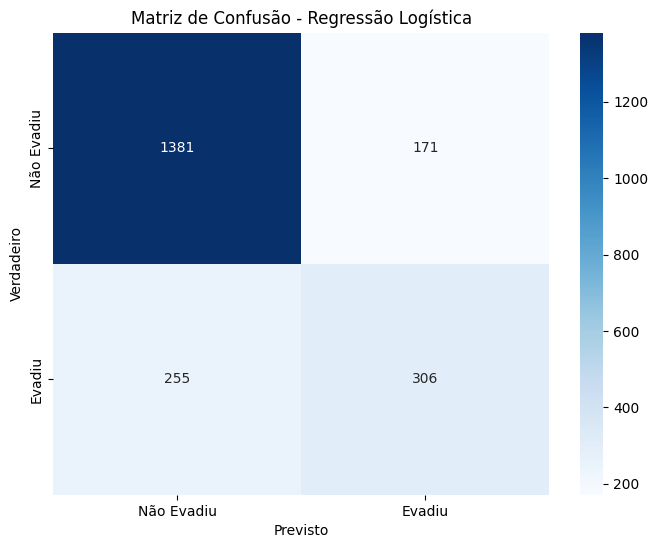

In [11]:
# 4. Matriz de Confusão
print("Matriz de Confusão:\n")
matriz_confusao_logistica = confusion_matrix(y_test, previsoes_logistica)
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusao_logistica, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Evadiu', 'Evadiu'],
            yticklabels=['Não Evadiu', 'Evadiu'])
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão - Regressão Logística')
plt.show()

## 4. Análise e Comparação dos Modelos
Com os dois modelos treinados, comparamos seus resultados e investigamos quais variáveis foram mais importantes para suas previsões.

### 4.1. Análise de Importância das Variáveis
Extraímos a importância das *features* do Random Forest e os coeficientes da Regressão Logística para entender quais fatores mais impactaram as decisões de cada modelo.

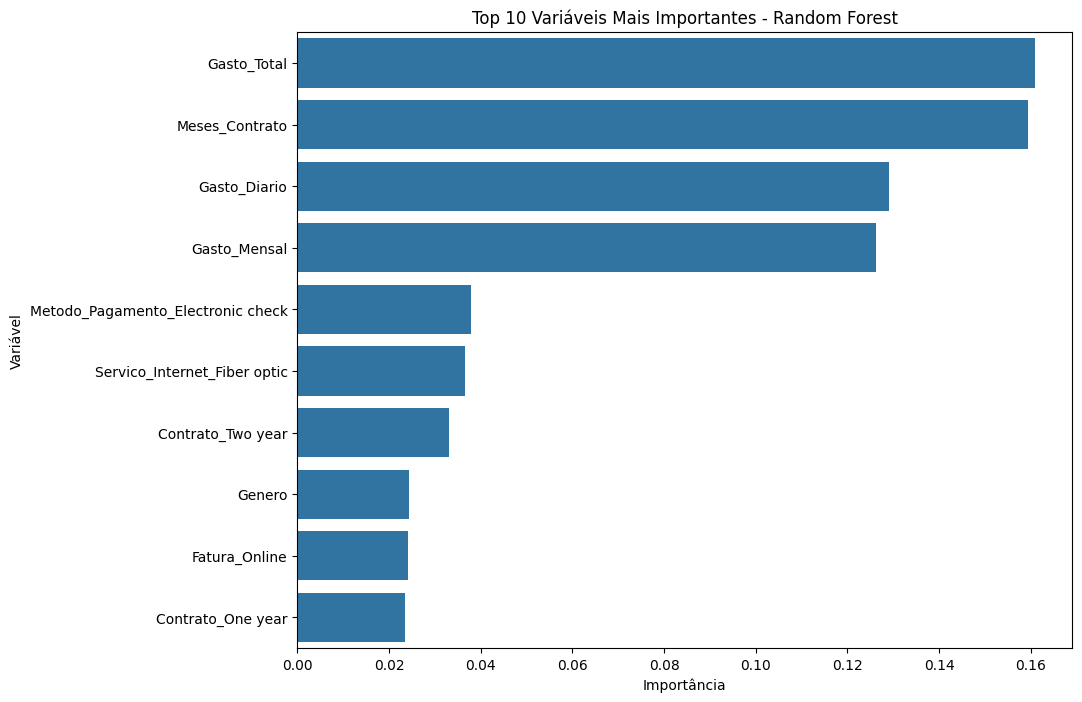

In [12]:
importancias_rf = pd.Series(modelo_rf.feature_importances_, index=X.columns)

# Ordenando as variáveis da mais para a menos importante
importancias_rf_ordenadas = importancias_rf.sort_values(ascending=False)

# Plotando as 10 variáveis mais importantes
plt.figure(figsize=(10, 8))
sns.barplot(x=importancias_rf_ordenadas.head(10), y=importancias_rf_ordenadas.head(10).index)
plt.title('Top 10 Variáveis Mais Importantes - Random Forest')
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.show()

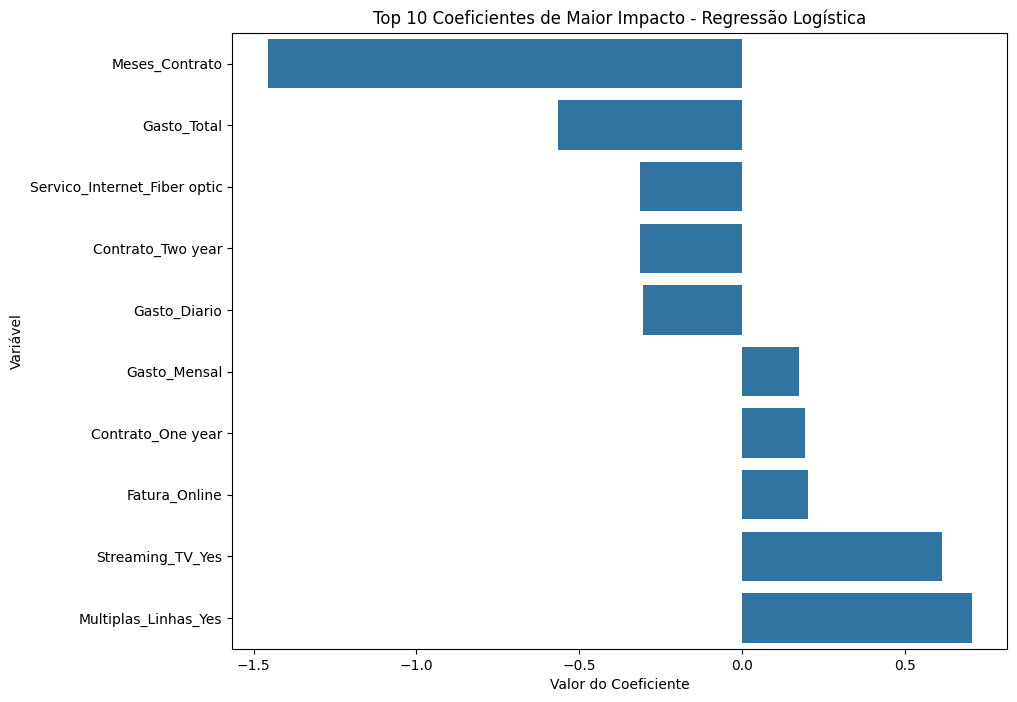

In [13]:
coeficientes_logistica = pd.Series(modelo_logistica.coef_[0], index=X.columns)

# Ordenando por valor absoluto para ver o maior impacto (positivo ou negativo)
coeficientes_logistica_ordenados = coeficientes_logistica.abs().sort_values(ascending=False)

# Plotando os 10 coeficientes de maior impacto
plt.figure(figsize=(10, 8))
sns.barplot(x=coeficientes_logistica[coeficientes_logistica_ordenados.head(10).index].sort_values(),
            y=coeficientes_logistica_ordenados.head(10).index)
plt.title('Top 10 Coeficientes de Maior Impacto - Regressão Logística')
plt.xlabel('Valor do Coeficiente')
plt.ylabel('Variável')
plt.show()

## 5. Relatório Final: Conclusão e Recomendações
Após a análise exploratória e a construção de dois modelos preditivos (Random Forest e Regressão Logística), foi possível identificar com clareza os principais fatores que influenciam a evasão de clientes na Telecom X.

### Comparação de Modelos

Ambos os modelos apresentaram um bom desempenho geral. No entanto, a **Regressão Logística (Acurácia: 80.22%, Recall: 54.4%)** superou ligeiramente o Random Forest (Acurácia: 78.61%, Recall: 49.2%), especialmente na capacidade de identificar corretamente os clientes que de facto cancelaram (métrica de Recall), que é o objetivo mais crítico para o negócio.

### Fatores de Maior Impacto no Churn

A análise de importância das variáveis, confirmada por ambos os modelos, revelou que os seguintes fatores são os mais determinantes para prever a evasão:

1.  **Tipo de Contrato:** Ter um **contrato mensal (`Month-to-month`)** é o indicador mais forte de risco de churn. A flexibilidade para cancelar sem penalidades incentiva a saída.
2.  **Tempo de Contrato (`Meses_Contrato`):** Clientes com **pouco tempo de casa** têm uma probabilidade muito maior de cancelar. A lealdade aumenta significativamente com o passar dos meses.
3.  **Gasto Mensal (`Gasto_Mensal`):** Faturas com **valores mensais mais elevados** estão positivamente correlacionadas com a evasão, sugerindo uma sensibilidade ao preço.
4.  **Serviço de Internet:** Clientes que contratam **Fibra Ótica** apresentam uma taxa de churn superior, o que pode indicar problemas de qualidade, preço ou desalinhamento de expectativas em relação a este serviço específico.

### Recomendações Estratégicas

Com base nestes fatores, a Telecom X pode direcionar as suas estratégias de retenção de forma muito mais eficaz, focando nos clientes que apresentam o perfil de risco identificado. As recomendações da Parte 1, como a criação de campanhas para migração de contratos mensais e um programa de *onboarding* para novos clientes, são reforçadas e validadas por esta análise preditiva.